/newpage

# Config e imports

In [33]:
import calculos_montaña as cmr
import numpy as np
import matplotlib.pyplot as plt
import Mnaf2025 as mnaf
import scipy.interpolate as scip
from scipy.interpolate import BSpline

# **Simulación en 2D**

## ***Definición de las curvas a usar***

En el paquete definido como calculos_montaña tenemos en esencia lo necesario para hacer una montaña rusa, lo primero que tenemos que hacer antes de generar una función interpolante es definir las partes que queremos que tenga nuestra montaña rusa.
Los elementos que mínimo debe de tener esta montaña rusa son una gran bajada, una montañita y un looping, por lo tanto nuestra montaña rusa será de la siguiente manera
- gran bajada
- looping
- montañita (gaussiana)
- pequeña bajada
- looping
- recta final de frenado

En calculos de montaña tenemos lo necesario para calcular por partes estas secciones, luego las uniremos de forma que quede mas o menos uniforme y se parezca a una montaña rusa.

In [9]:
# Definimos la gran bajada de la montaña rusa
Gran_bajada = cmr.curva3d('s',np.linspace(-150,150,100),A=130,args=[0.05])

# Definimos el primer loop de la montaña rusa
Loop1 = cmr.curva3d('l',np.linspace(0,1.79,20),A=40,C=[Gran_bajada[0][-1],0,Gran_bajada[2][-1]],args=[0])

# Definimos montañita (gaussina)
Montañita = cmr.curva3d('g',np.linspace(-250,250,50),A=60,C=[Loop1[0][-1]+250,0,Loop1[2][-1]],args=[95])

# Definimos la pequeña bajada
Pequeña_bajada = cmr.curva3d('s',np.linspace(-100,100,20),A=20,C=[Montañita[0][-1]+100,0,Montañita[2][-1]-20],args=[0.1])

# Definimos el segundo loop de la montaña rusa
Loop2 = cmr.curva3d('l',np.linspace(0,1.79,10),A=30,C=[Pequeña_bajada[0][-1],0,Pequeña_bajada[2][-1]],args=[0])

# Recta final frenado
Recta_final = [Pequeña_bajada[0][-1]+np.linspace(0,200,20)+60,np.zeros(20),np.full(20,Loop2[2][-1])]

## ***Dibujo de la montaña rusa***

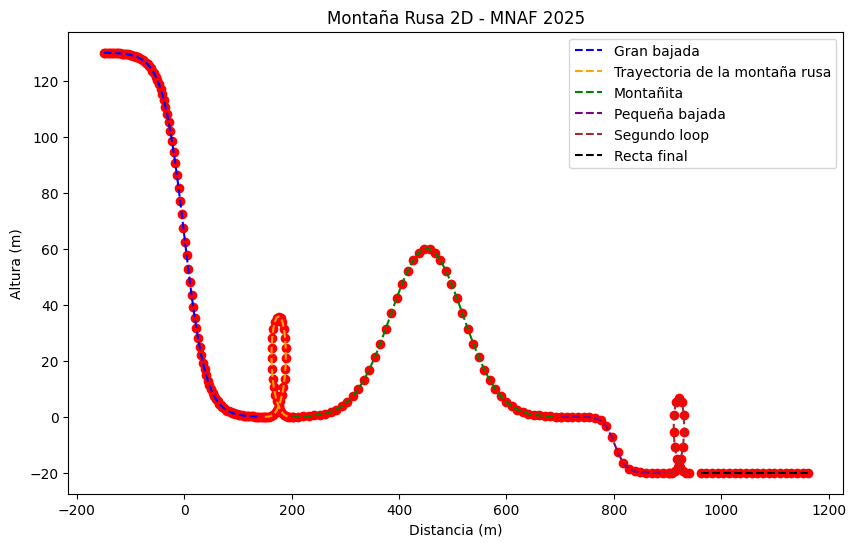

In [10]:
# ==============================================
# Gráfica de la montaña rusa
# ==============================================

plt.figure(figsize=(10,6))

# Graficar la gran bajada
plt.plot(Gran_bajada[0], Gran_bajada[2], 'o', color='red')
plt.plot(Gran_bajada[0], Gran_bajada[2], '--', color='blue', label='Gran bajada')

# Graficar el primer loop
plt.plot(Loop1[0], Loop1[2], 'o', color='red')
plt.plot(Loop1[0], Loop1[2], '--', color='orange', label='Trayectoria de la montaña rusa')

# Graficar la montañita
plt.plot(Montañita[0], Montañita[2], 'o', color='red')
plt.plot(Montañita[0], Montañita[2], '--', color='green', label='Montañita')

# Graficar la pequeña bajada
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], 'o', color='red')
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], '--', color='purple', label='Pequeña bajada')

# Graficar el segundo loop
plt.plot(Loop2[0], Loop2[2], 'o', color='red')
plt.plot(Loop2[0], Loop2[2], '--', color='brown', label='Segundo loop')

# Graficar la recta final
plt.plot(Recta_final[0], Recta_final[2], 'o', color='red')
plt.plot(Recta_final[0], Recta_final[2], '--', color='black', label='Recta final')

# Configuraciones de la gráfica
plt.legend()
plt.title('Montaña Rusa 2D - MNAF 2025')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.show()



## ***Construimos la expresión paramétrica***


In [31]:
# Función que genera la expresión paramétrica
def montaña_rusa_parametrica(X_data=None, Z_data=None, Y_data=None, grado=3):
    '''
    Construye la expresión paramétrica r(t) mediante B-splines.
    
    Parámetros:
    -----------
    X_data : array-like
        Coordenadas horizontales (distancia)
    Z_data : array-like
        Coordenadas verticales (altura)
    grado : int
        Grado del B-spline (default=3, cúbico)
    
    Retorna:
    --------
    curva_bspline: expresión parámetrica evaluable con un parámetro [0,1]
    '''
    
    # Como hacemos una función 3D, si falta alguna coordenada la llenamos con ceros
    if X_data is None:
        X_data = np.full(len(Z_data), 0)
    elif Z_data is None:
        Z_data = np.full(len(X_data), 0)
    elif Y_data is None:
        Y_data = np.full(len(X_data), 0)
    
    # definimos los Puntos de control, serán los mismos datos
    puntos_control = np.array([X_data, Z_data, Y_data])  # Cada fila es una coordenada (X, Z, Y)

    # Definimos los nodos, debe cumplir la condición len(nodos) = len(puntos_control) + grado + 1
    nodos = np.array([0]*(grado) + list(np.linspace(0, 1, len(X_data)-grado)) + [1]*(grado)) #Ponemos los nodos al inicio y al final repetidos grado+1 veces para forzar a que la curva pase por los puntos extremos
    
    # Usamos la clase BSpline de scipy.interpolate
    curva_bspline = BSpline(nodos, puntos_control.T, grado)
    
    return curva_bspline
    

### ***Visualización de lo obtenido tras interpolar***

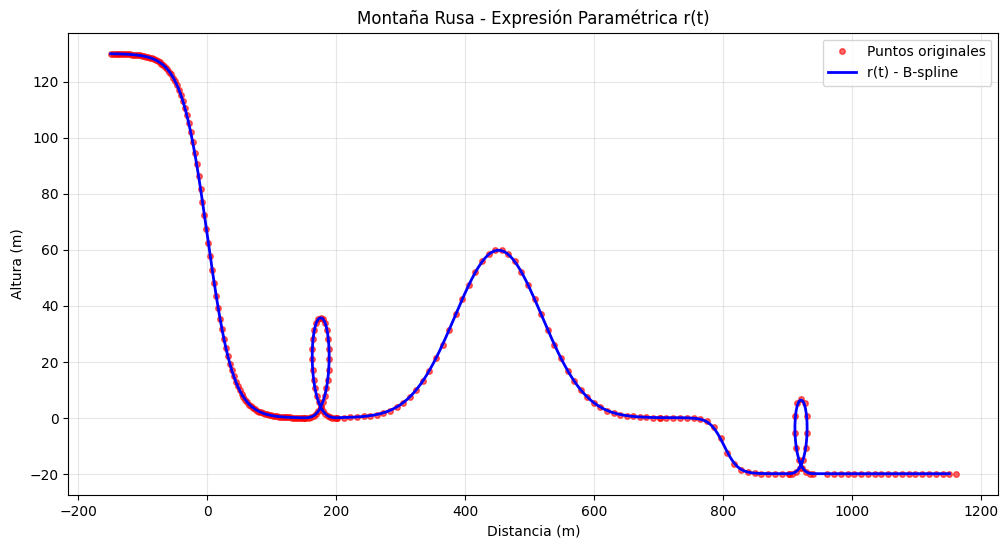

In [32]:
# Visualización usando la expresión paramétrica r(t)

#Construimos la expresión
Curva_parametrica = montaña_rusa_parametrica(
    X_data = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
    Z_data = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
)

# Evaluamos
t_eval = np.linspace(0, 1, 500)
Puntos_de_interpolación=Curva_parametrica(t_eval)

plt.figure(figsize=(12, 6))

# Gráfica comparativa
plt.plot(np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
         np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
         'o', color='red', markersize=4, label='Puntos originales', alpha=0.6)
plt.plot(Puntos_de_interpolación[:,0], Puntos_de_interpolación[:,1], '-', color='blue', linewidth=2, label='r(t) - B-spline')

plt.legend()
plt.title('Montaña Rusa - Expresión Paramétrica r(t)')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.grid(True, alpha=0.3)
plt.show()


## ***Caso sin fricción***


Veamos como se comporta nuestra montaña rusa en caso de que no exista fricción

In [ ]:
# ==============================================
# PREPARACIÓN DEL SISTEMA EDO
# ==============================================

# Concatenar datos completos de la montaña rusa
Distancia_data = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]])
Altura_data = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]])

# Calcular derivadas de la curva usando pkgmrusa


# Parámetros físicos del sistema
masa = 500.0         # kg - masa del vagón
mu = 0.0             # coeficiente de rozamiento (0 = conservativo)
ca = 0.0             # coeficiente de arrastre aerodinámico (0 = conservativo)
Sf = 2.0             # m² - superficie frontal
rho_aire = 1.225     # kg/m³ - densidad del aire
g = 9.81             # m/s² - gravedad


# Condiciones iniciales [parámetro u0, velocidad v0]
u0 = 0.0              # inicio de la curva
v0 = 1.0              # m/s - velocidad inicial
y0 = [u0, v0]



print("="*70)
print("SISTEMA EDO - CASO CONSERVATIVO")
print("="*70)
print(f"Parámetros físicos:")
print(f"  • Masa: {masa} kg")
print(f"  • Coef. rozamiento μ: {mu} (SIN FRICCIÓN)")
print(f"  • Coef. arrastre ca: {ca} (SIN ROZAMIENTO)")
print(f"  • Gravedad: {g} m/s²")
print(f"\nCondiciones iniciales:")
print(f"  • Posición inicial: u₀ = {u0}")
print(f"  • Velocidad inicial: v₀ = {v0} m/s")


SISTEMA EDO - CASO CONSERVATIVO
Parámetros físicos:
  • Masa: 500.0 kg
  • Coef. rozamiento μ: 0.0 (SIN FRICCIÓN)
  • Coef. arrastre ca: 0.0 (SIN ROZAMIENTO)
  • Gravedad: 9.81 m/s²

Condiciones iniciales:
  • Posición inicial: u₀ = 0.0
  • Velocidad inicial: v₀ = 1.0 m/s

✓ Sistema preparado


### ***Comparación de Métodos Numéricos***

In [ ]:
# Metodos a usar
Metodos=["RK23","RK25"]